## Import Necessary Libraries

In [6]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt
import matplotlib.pyplot as plt

## Import Datasets

In [2]:
airline_data=pd.read_excel('Airlines+Data.xlsx')
airline_data['Month']

0    1995-01-01
1    1995-02-01
2    1995-03-01
3    1995-04-01
4    1995-05-01
        ...    
91   2002-08-01
92   2002-09-01
93   2002-10-01
94   2002-11-01
95   2002-12-01
Name: Month, Length: 96, dtype: datetime64[ns]

## Data Understanding

In [3]:
airline_data.shape

(96, 2)

In [4]:
airline_data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [5]:
airline_data.isnull().sum()

Month         0
Passengers    0
dtype: int64

### Inference :
* The data have 2 features and 96 records

* The datatype of the features are assigned coorectly and there is no null values

## Data visualization

<AxesSubplot:>

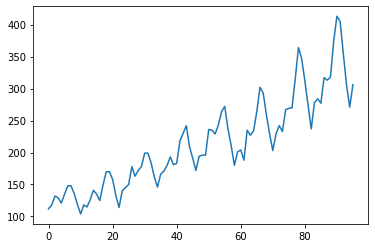

In [7]:
airline_data['Passengers'].plot()

<AxesSubplot:>

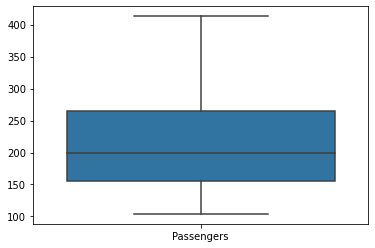

In [8]:
sns.boxplot(data=airline_data)

<AxesSubplot:>

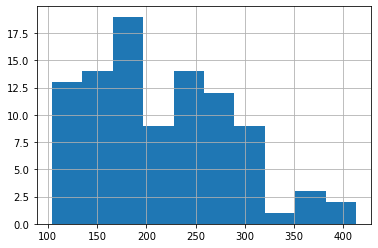

In [9]:
airline_data['Passengers'].hist()

<AxesSubplot:ylabel='Density'>

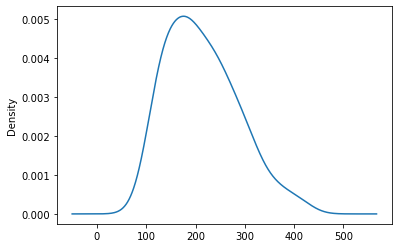

In [10]:
airline_data['Passengers'].plot(kind='kde')

<AxesSubplot:xlabel='Passengers', ylabel='Density'>

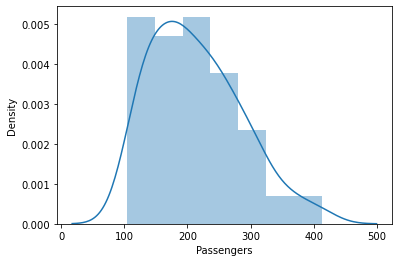

In [11]:
sns.distplot(airline_data['Passengers'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

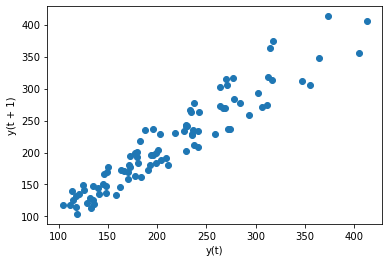

In [12]:
from pandas.plotting import lag_plot

lag_plot(airline_data['Passengers'])

## Data driven modelling

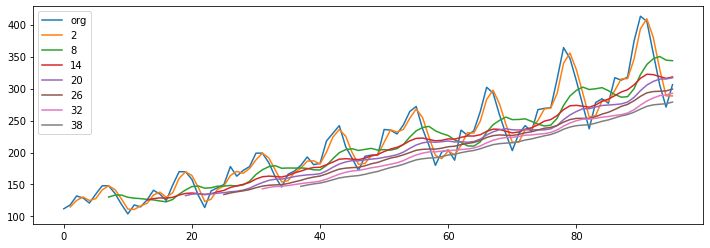

In [13]:
plt.figure(figsize=(12,4))
airline_data['Passengers'].plot(label="org")
for i in range(2,40,6):
    airline_data['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

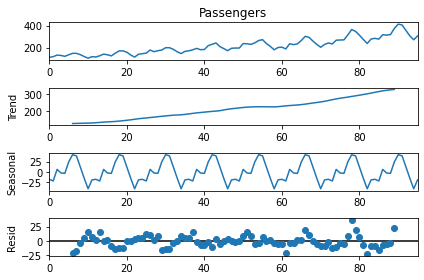

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(airline_data['Passengers'],period=12)
decompose_ts_add.plot()
plt.show()

### ACF Plot and PACF Plot

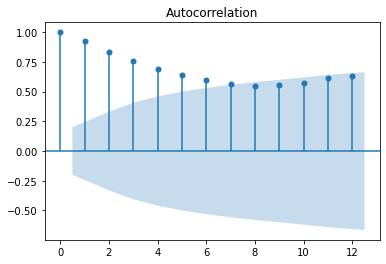

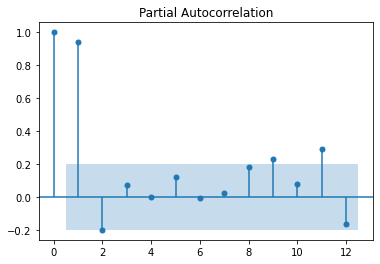

In [15]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airline_data['Passengers'],lags=12)
tsa_plots.plot_pacf(airline_data['Passengers'],lags=12)
plt.show()

### Simple exponential method

In [16]:
train=airline_data.head(80)
test=airline_data.tail(15)

In [17]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
ses_rms=mean_absolute_percentage_error(pred_ses,test['Passengers'])*100 
ses_rms

13.307089401087206

### Holt method

In [18]:
from statsmodels.tsa.holtwinters import Holt

hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
hw_rms=mean_absolute_percentage_error(pred_hw,test['Passengers'])*100 
hw_rms

33.892942557355475

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])

hw_ma_rms=mean_absolute_percentage_error(pred_hwe_mul_add,test['Passengers'])*100 
hw_ma_rms

3.5738995677117606

### Holts winter exponential smoothing with additive seasonality and additive trend

In [20]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])

hw_aa_rms=mean_absolute_percentage_error(pred_hwe_add_add,test['Passengers'])*100 
hw_aa_rms

7.413789108373307

### ARMA Model

In [21]:
from statsmodels.tsa.arima_model import ARMA

In [22]:
ARMAmodel = ARMA(train['Passengers'], order=(1, 1)) #model with AR=0 and MA=1
ARMAmodel_fit = ARMAmodel.fit()

ARMA_pred = ARMAmodel_fit.predict(0,14)
ARMA_pred

arma_rms=mean_absolute_percentage_error(ARMA_pred,test['Passengers'])*100 
arma_rms

139.12522435948836

### ARIMA Model

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
ARIMAmodel = ARIMA(train['Passengers'], order=(1, 1, 2)) #notice p,d and q value here
ARIMA_model_fit = ARIMAmodel.fit()

ARIMA_pred = ARIMA_model_fit.predict(1,15,typ='levels')

arima_rms=mean_absolute_percentage_error(ARIMA_pred,test['Passengers'])*100
arima_rms

143.75871125852382

### Converting non stationary data to stationary data to improve ARIMA model

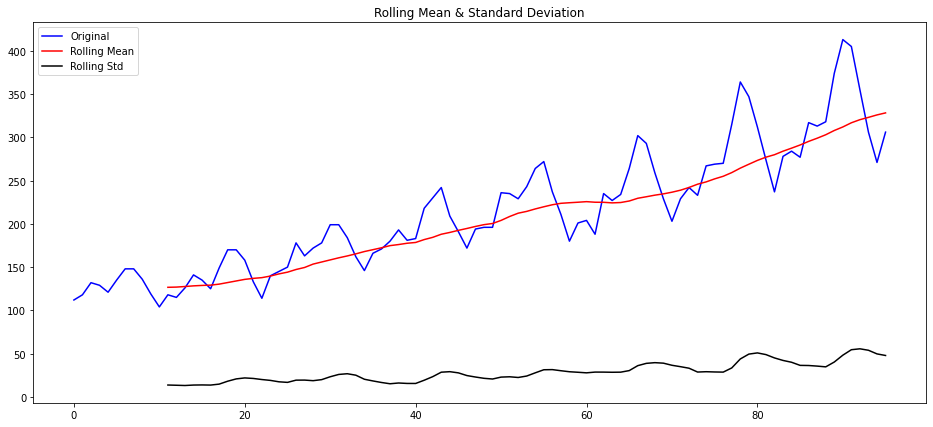

In [25]:
rolLmean = airline_data['Passengers'].rolling(12).mean() # 12 entries
rolLstd = airline_data['Passengers'].rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(airline_data['Passengers'], color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Making stationary

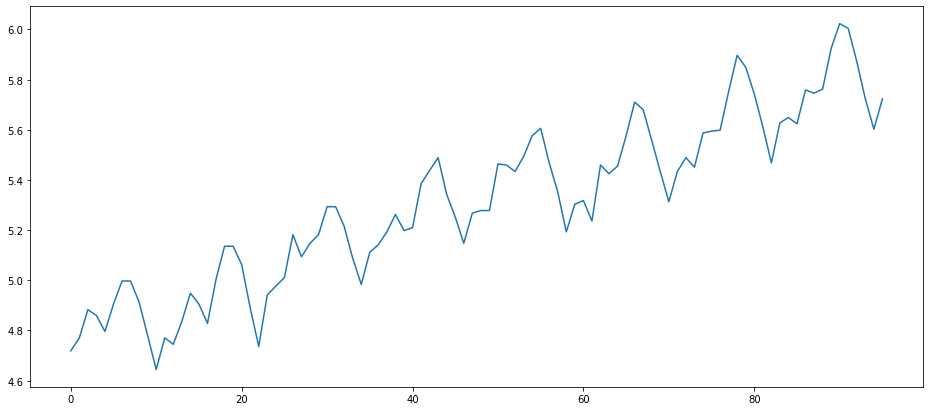

In [26]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(airline_data['Passengers'])#to transform to stationary from non-stationary
plt.plot(ts_log)

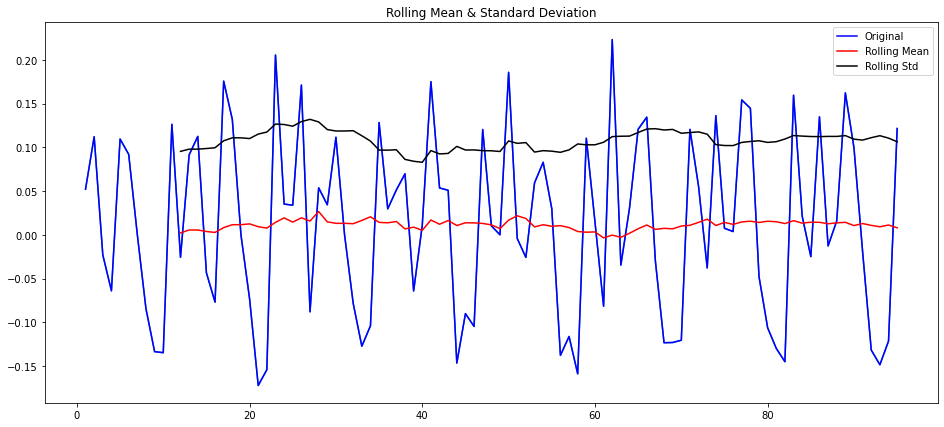

In [27]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift() # I will shift the time series by 1 and subtract from the original TS.
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [28]:
#after differnecing, there is no pattern in the mean. No upward trend.No standard. 

In [29]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12)

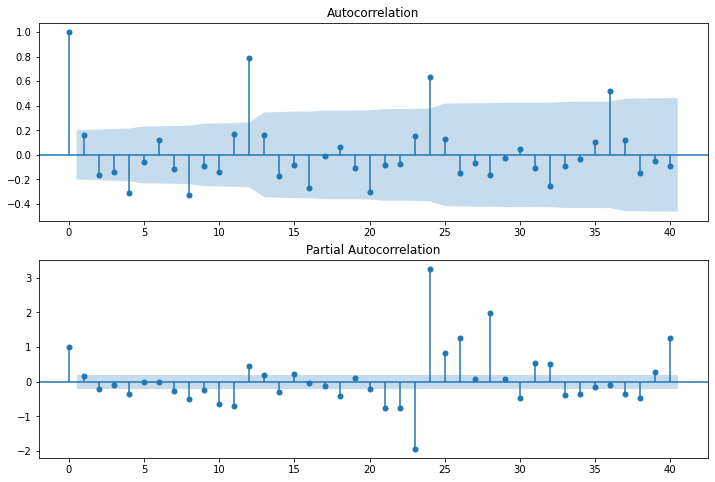

In [30]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=40,ax=ax2)

In [31]:
ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

C:\Users\sangeethraj K\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\sangeethraj K\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\sangeethraj K\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


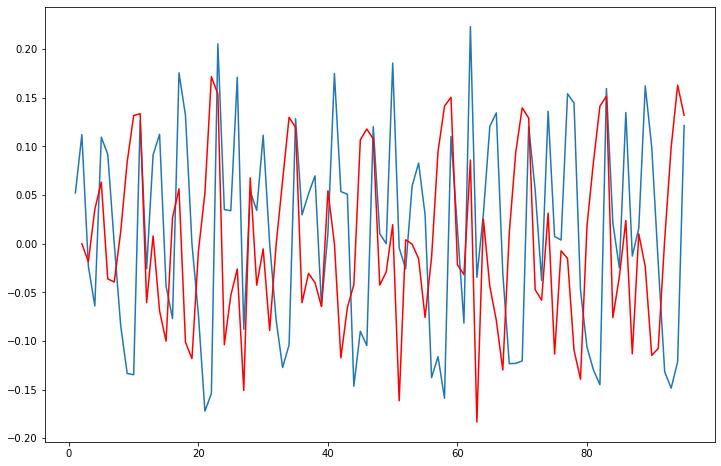

In [32]:
plt.figure(figsize=(12,8))
ts_log_diff.dropna(inplace=True)
model = ARIMA(ts_log_diff, order=(4,1,2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

## Model based Forcasting

In [33]:
airline_data_model=airline_data

In [34]:
airline_data_model.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [35]:
airline_data_model['Month']=airline_data_model['Month'].astype('str')

In [36]:
airline_data_model['Year']=0
for i in range(len(airline_data_model)):
    p=airline_data_model['Month'][i]
    airline_data_model['Year'][i]=p[0:4]

In [37]:
airline_data_model['Months']=0
for i in range(len(airline_data_model)):
    p=airline_data_model['Month'][i]
    airline_data_model['Months'][i]=p[5:7]

In [38]:
airline_data_model

,Month,Passengers,Year,Months
0,1995-01-01,112,1995,1
1,1995-02-01,118,1995,2
2,1995-03-01,132,1995,3
3,1995-04-01,129,1995,4
4,1995-05-01,121,1995,5
...,...,...,...,...
91,2002-08-01,405,2002,8
92,2002-09-01,355,2002,9
93,2002-10-01,306,2002,10
94,2002-11-01,271,2002,11


In [39]:
df_dummies = pd.DataFrame(pd.get_dummies(airline_data_model['Months']))

In [40]:
airlines_df =pd.concat([airline_data_model,df_dummies],axis= 1)
airlines_df

,Month,Passengers,Year,Months,1,2,3,4,5,6,7,8,9,10,11,12
0,1995-01-01,112,1995,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,1995,2,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,1995,3,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,1995,4,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,1995,5,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002,8,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-01,355,2002,9,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-01,306,2002,10,0,0,0,0,0,0,0,0,0,1,0,0
94,2002-11-01,271,2002,11,0,0,0,0,0,0,0,0,0,0,1,0


In [41]:
airlines_df['tsquare']=airlines_df['Months'].apply(lambda x:x**2)

In [42]:
from numpy import log
airlines_df['log_passengers']=airlines_df['Passengers'].apply(lambda x:log(x))

In [43]:
airlines_df

,Month,Passengers,Year,Months,1,2,3,4,5,6,7,8,9,10,11,12,tsquare,log_passengers
0,1995-01-01,112,1995,1,1,0,0,0,0,0,0,0,0,0,0,0,1,4.718499
1,1995-02-01,118,1995,2,0,1,0,0,0,0,0,0,0,0,0,0,4,4.770685
2,1995-03-01,132,1995,3,0,0,1,0,0,0,0,0,0,0,0,0,9,4.882802
3,1995-04-01,129,1995,4,0,0,0,1,0,0,0,0,0,0,0,0,16,4.859812
4,1995-05-01,121,1995,5,0,0,0,0,1,0,0,0,0,0,0,0,25,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002,8,0,0,0,0,0,0,0,1,0,0,0,0,64,6.003887
92,2002-09-01,355,2002,9,0,0,0,0,0,0,0,0,1,0,0,0,81,5.872118
93,2002-10-01,306,2002,10,0,0,0,0,0,0,0,0,0,1,0,0,100,5.723585
94,2002-11-01,271,2002,11,0,0,0,0,0,0,0,0,0,0,1,0,121,5.602119


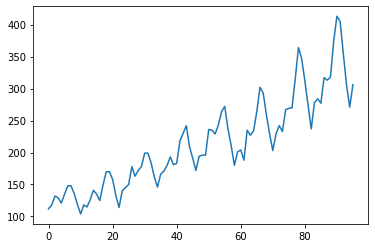

In [44]:
import matplotlib.pyplot as plt
plt.plot(airlines_df['Passengers'])

In [45]:
airlines_df=airlines_df.rename(columns={1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})

In [46]:
train_model=airlines_df.head(80)
test_model=airlines_df.tail(15)

### Linear model

In [47]:
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_absolute_percentage_error

linear_model = smf.ols('Passengers~Months',data=train_model).fit()
linear_pred=linear_model.predict(test_model['Months'])

linear_rms=mean_absolute_percentage_error(test_model['Passengers'],linear_pred)*100
linear_rms

37.13562686329389

### Exponential model

In [48]:
exponential_model = smf.ols('log_passengers~Months',data=train_model).fit()
exponential_pred=exponential_model.predict(test_model['Months'])

exp_rms=mean_absolute_percentage_error(test_model['Passengers'],exponential_pred)*100
exp_rms

98.30419643524579

In [49]:
train_model

,Month,Passengers,Year,Months,jan,feb,mar,apr,may,jun,july,aug,sep,oct,nov,dec,tsquare,log_passengers
0,1995-01-01,112,1995,1,1,0,0,0,0,0,0,0,0,0,0,0,1,4.718499
1,1995-02-01,118,1995,2,0,1,0,0,0,0,0,0,0,0,0,0,4,4.770685
2,1995-03-01,132,1995,3,0,0,1,0,0,0,0,0,0,0,0,0,9,4.882802
3,1995-04-01,129,1995,4,0,0,0,1,0,0,0,0,0,0,0,0,16,4.859812
4,1995-05-01,121,1995,5,0,0,0,0,1,0,0,0,0,0,0,0,25,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2001-04-01,269,2001,4,0,0,0,1,0,0,0,0,0,0,0,0,16,5.594711
76,2001-05-01,270,2001,5,0,0,0,0,1,0,0,0,0,0,0,0,25,5.598422
77,2001-06-01,315,2001,6,0,0,0,0,0,1,0,0,0,0,0,0,36,5.752573
78,2001-07-01,364,2001,7,0,0,0,0,0,0,1,0,0,0,0,0,49,5.897154


In [50]:
quaratic_model = smf.ols('Passengers~(Months+tsquare)',data=train_model).fit()
#quaratic_model.fit()
quaratic_pred=quaratic_model.predict(test_model[['Months','tsquare']])

qua_rms=mean_absolute_percentage_error(test_model['Passengers'],quaratic_pred)*100

In [51]:
add_sea = smf.ols("Passengers~jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
add_pred=add_sea.predict(test_model[['jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

add_rms=mean_absolute_percentage_error(test_model['Passengers'],add_pred)*100
add_rms

40.28314165835847

In [52]:
add_qua_model=smf.ols("Passengers~Months+tsquare+jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
add_qua_pred=add_qua_model.predict(test_model[['Months','tsquare','jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

add_qua_rms=mean_absolute_percentage_error(test_model['Passengers'],add_qua_pred)*100
add_qua_rms

40.28314165837238

In [53]:
mul_sea = smf.ols("log_passengers~jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
mul_pred=mul_sea.predict(test_model[['jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

mul_rms=mean_absolute_percentage_error(test_model['Passengers'],mul_pred)*100
mul_rms

98.31984707397673

In [54]:
mul_add_model=smf.ols("Passengers~Months+jan+feb+mar+apr+may+jun+july+aug+sep+oct+nov+dec",data=train_model).fit()
mul_add_pred=mul_add_model.predict(test_model[['Months','jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec']])

mul_add_rms=mean_absolute_percentage_error(test_model['Passengers'],mul_add_pred)*100
mul_add_rms

40.283141658358474

In [55]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea",'rmse_ses','rmse_holt','rmse_holt_ma','rmse_holt_aa','rmse_arma','rmse_arima']),
        "RMSE_Values":pd.Series([linear_rms,exp_rms,qua_rms,add_rms,add_qua_rms,mul_rms,mul_add_rms,ses_rms,hw_rms,hw_ma_rms,hw_aa_rms,arma_rms,arima_rms])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
9,rmse_holt_ma,3.573900
10,rmse_holt_aa,7.413789
7,rmse_ses,13.307089
8,rmse_holt,33.892943
0,rmse_linear,37.135627
2,rmse_Quad,39.211566
3,rmse_add_sea,40.283142
6,rmse_Mult_add_sea,40.283142
4,rmse_add_sea_quad,40.283142
1,rmse_Exp,98.304196


### Inference:

* The mean absolute percentage error of Holts winter exponential smoothing with multiplicative seasonality and additive trend model is comparitively low compared to all other model

* Hence, the forecast model can be built by Holts winter exponential smoothing with multiplicative seasonality and additive trend

## Final model

In [56]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 

In [57]:
hwe_model_mul_add.forecast(10)

80    310.167059
81    273.377820
82    239.337849
83    270.781202
84    276.719778
85    274.057299
86    317.640605
87    307.795642
88    306.484210
89    343.878921
dtype: float64